In [351]:
import pandas as pd
import nltk
import lightgbm
import yellowbrick
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn import feature_extraction
from gensim.models import Word2Vec



stopwords = set(stopwords.words('english'))
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

In [352]:
train['text_raw'] = train['text']

# Clean

In [494]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
def metrics(m): 
    # AUC
    vis = yellowbrick.ROCAUC(m, classes=[0,1])
    vis.fit(X_train,y_train)
    vis.score(X_test,y_test)
    vis.show()

    # F1 Score
    scores = cross_val_score(m, X_train, y_train, cv=3, scoring='f1')
    print(scores.mean())

    # # Heatmap
    # preds = m.predict(X_test)
    # sns.heatmap(confusion_matrix(y_test.tolist(),preds), cmap='rocket_r',annot=True)
    # plt.show()

In [3]:
def rm_sw(x): 
    tok = word_tokenize(x)
    l = [word for word in tok if word not in stopwords]
    return l 

def vecs(x): 
    return [Word2Vec(l) for l in x]


train['text'] = train['text'].apply(rm_sw)
test['text'] = test['text'].apply(rm_sw)
train['text'] = train['text'].apply(lambda x: ' '.join(x))
test['text'] = test['text'].apply(lambda x: ' '.join(x))

tok_sents = train['text'].apply(sent_tokenize)
train['toks'] = tok_sents


In [4]:

model = Word2Vec(tok_sents, min_count=1, vector_size = 100)
model.wv[train['toks'][5]].shape

train['vecs'] = train['toks'].apply(lambda x : model.wv[x])
def document_vector(array_of_word_vectors):
    return array_of_word_vectors.mean(axis=0) 
train['vecs'] = train['vecs'].apply(document_vector)

df = pd.DataFrame()
for i in range(2): 
    df = pd.concat([df, train['vecs'].str[i]], axis=1)

X=train['vecs'].apply(pd.Series)




# Count Vectorizer

In [5]:
cv = feature_extraction.text.CountVectorizer()
train_vectors = cv.fit_transform(train['text'])
test_vectors = cv.transform(test['text'])
train_vectors = train_vectors.astype('float')
test_vectors = test_vectors.astype('float')
train_vectors[0].todense().shape

(1, 21617)

# TFIDF

**Remove special characters**

In [422]:
# train['text_clean'] = train['text_raw'].str.replace("[^a-zA-Z0-9!.']", ' ')
# train['text_clean'] = train['text_raw'].str.lower().str.replace('https','http')

In [488]:
from sklearn.feature_extraction.text import TfidfVectorizer
vec = TfidfVectorizer(
    stop_words=stopwords, 
    ngram_range=(1,1),
    lowercase=True,
    max_features=1200 
    )
train_vectors = vec.fit_transform(train['text_raw'])

# Cluster Feats

In [489]:
from sklearn.cluster import KMeans
k = KMeans(
    n_clusters=2,
    random_state=0,
    )
k.fit(train_vectors)
X = pd.DataFrame(train_vectors.todense())
X['cluster'] = k.labels_

# View Clusters

<AxesSubplot:xlabel='0', ylabel='1'>

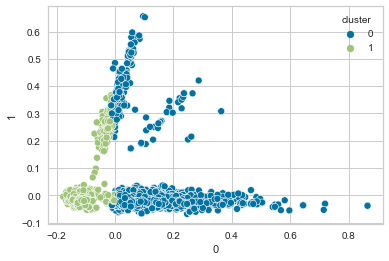

In [490]:
from sklearn.decomposition import PCA
t = X.iloc[:,:-1]
pca = PCA(n_components=2)
z = pd.DataFrame(pca.fit_transform(t))
z['cluster'] = k.labels_
sns.scatterplot(x=z[0], y=z[1],  hue=z['cluster'])

# Train

In [521]:
# With KMeans + TFIDF
feat_names = (list(vec.get_feature_names_out()))
feat_names.append('cluster')
X.columns = feat_names
X = X.drop(columns=[x for x in X.columns if 'û' in x])
X_train,X_test,y_train,y_test = train_test_split(
                                        X, 
                                        train['target'],
                                        stratify=train['target'], 
                                        random_state=0, 
                                        test_size=.2
                                        )

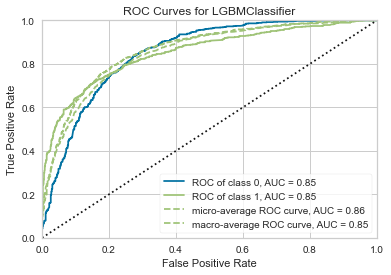

0.6886189560304863


In [522]:
# With like 0.6943139623816387

m = lightgbm.LGBMClassifier(
    num_leaves=30,
    max_depth=-1,
    n_estimators=100,
    learning_rate=.14
)
m.fit(X_train, y_train)
metrics(m)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

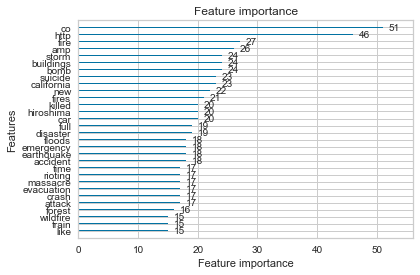

In [523]:
lightgbm.plot_importance(m, max_num_features=30, )

# ON Test Set

In [529]:
m = lightgbm.LGBMClassifier(
    num_leaves=31,
    max_depth=-1,
    n_estimators=175, 
    )
# FULL TRAIN SET
clusters = k.predict(train_vectors)
X = pd.DataFrame(train_vectors.todense())
X['cluster'] = clusters
X.columns = feat_names
X.drop(columns=[x for x in X.columns if 'û' in x])
m.fit(X, train['target'])

# TEST DATA
test_vectors = vec.transform(test['text'])
clusters = k.predict(test_vectors)
X = pd.DataFrame(test_vectors.todense())
X['cluster'] = clusters
X.columns = feat_names
X.drop(columns=[x for x in X.columns if 'û' in x])

preds = m.predict(X)
test['target'] = preds
test.set_index('id')['target'].to_csv('tt.csv')